In [62]:
%%HTML
<div align='right'>
<script>
    code_show=true;
    function code_toggle() {
     if (code_show){
     $('div.input').hide();
     } else {
     $('div.input').show();
     }
     code_show = !code_show
    }
    $( document ).ready(code_toggle);
    </script>
    <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>
    </div>

## Flash density under feature envelope

What if we want to calculate the flash density contained within each feature. We have the orientation and the major and minor axis of each TITAN feature as an elipse. So we can use the following equation to figure out whether any given point is contained in the envelope during the time interval preceeding the TITAN time (is titan right labeled?). 

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
from pointprocess import *
from lightning_setup import *
from titan import *
from cartopy.io.img_tiles import StamenTerrain

%matplotlib inline

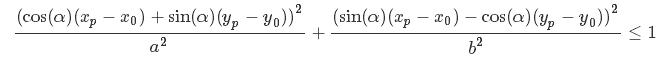

In [6]:
from IPython.display import Image
Image('http://i.stack.imgur.com/J0p9k.png')

The above function describes how to determine whether a point at xp, yp is contained by an elipse centered at x0, y0 with and angle of orientation alpha from horizontal and with major and minor axes a, b. After we determine which flashes area contained within each feature ellipse, then we can get the flash density for each feature at each time step. Then we can ask questions about what characterizes a TITAN feature with high flash density.

In [7]:
tr = df.index.unique().sort_values()

In [8]:
# It is helpful to redefine a smaller dataframe with better names for the titan data
# and not time indexed since time is non-unique
cols = [n for n in df.columns for j in ['EnvelopeArea', 
                                        'EnvelopeOrientation', 
                                        'EnvelopeMajorRadius', 
                                        'EnvelopeMinorRadius',
                                        'ReflCentroidLat', 
                                        'ReflCentroidLon',
                                        'TiltO', 'TiltA'] if j in n]

mini_df = df[cols]

In [9]:
mini_df.columns = ['lat','lon','area','orient','major', 'minor', 'tilt_angle','tilt_orient']
mini_df = mini_df.reset_index()

In [10]:
c = Region(city=cities['cedar'])

In [11]:
ds = c.get_daily_ds(storm, func=None)

In [12]:
for n in mini_df.index:
    tot=0
    tot2=0
    tilt_tot=0
    tilt_tot2=0
    it = tr.get_loc(mini_df.loc[n, 'date_time'])
    if it == 0:
        ds0 = ds.cloud_ground[(ds.time>(tr[it] - pd.Timedelta(minutes=5)).asm8) & 
                              (ds.time<=tr[it].asm8) & 
                              (ds.cloud_ground=='G')]
    else:
        ds0 = ds.cloud_ground[(ds.time>tr[it-1].asm8) & 
                              (ds.time<=tr[it].asm8) & (ds.cloud_ground=='G')]
    x = ds0.lon.values
    y = ds0.lat.values
    s = mini_df.loc[n]
    for yp, xp in zip(y, x):
        boo = in_envelope(s, yp, xp)
        boo2 = in_envelope(s, yp, xp, 2)
        if boo:
            tilt_tot+=up_tilt(s, yp, xp)
        if boo2:
            tilt_tot2+=up_tilt(s, yp, xp)
        tot+=boo
        tot2+=boo2
    mini_df.set_value(n, 'FC', tot)
    mini_df.set_value(n, 'FC_2', tot2)
    mini_df.set_value(n, 'up_tilt', tilt_tot)
    mini_df.set_value(n, 'up_tilt_2', tilt_tot2)
mini_df.set_value(mini_df.index,'FD', mini_df.FC/mini_df.area)
mini_df.set_value(mini_df.index,'FD_2', mini_df.FC_2/(mini_df.area*2))
mini_df.set_value(mini_df.index,'tilt_ratio', mini_df.up_tilt/mini_df.FC)
mini_df.set_value(mini_df.index,'tilt_ratio_2', mini_df.up_tilt_2/mini_df.FC_2);

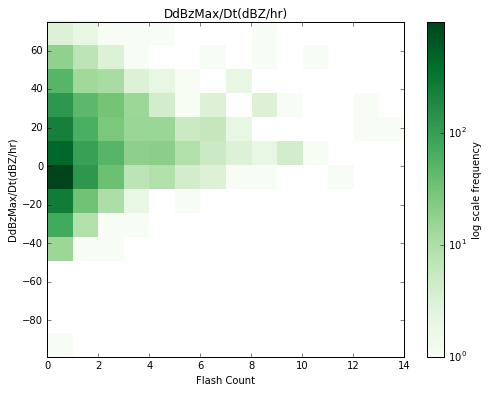

In [67]:
import ipywidgets as widgets
from IPython.display import display

def plot_param(param):
    global df
    global mini_df
    plt.figure(figsize=(8,6))
    plt.hist2d(x=mini_df.FC, y=df[param], bins=14,norm=LogNorm(), cmap='Greens')
    #plt.hexbin(x=mini_df.FC, y=df[param], bins='log', gridsize=10, cmap='Greens')
    plt.colorbar(label='log scale frequency')
    plt.ylabel(param)
    plt.xlabel('Flash Count')
    plt.title(param)

paramW = widgets.Select(options=list(df.columns))
j = widgets.interactive(plot_param, param=paramW)
display(j)

## Tilt

Now we will be trying to assess the validity of this statement. If “Cloud slope” is given by TiltAngle and TiltOrientation, lightning may be concentrated in the downslope portion of the cloud.

In [68]:
mini_df[(20<mini_df['tilt_angle']) & (mini_df['tilt_angle']<50)][['tilt_ratio', 'tilt_ratio_2']].describe()

,tilt_ratio,tilt_ratio_2
count,261.000000,321.000000
mean,0.627197,0.611057
std,0.425085,0.425122
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.888889,0.750000
75%,1.000000,1.000000
max,1.000000,1.000000


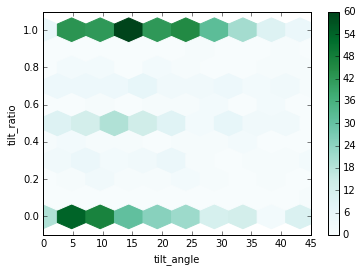

In [69]:
mini_df.plot.hexbin(x='tilt_angle', y='tilt_ratio', gridsize=(20, 5), sharex=False)
plt.ylim(-.1, 1.1)
plt.xlim(0, 45);

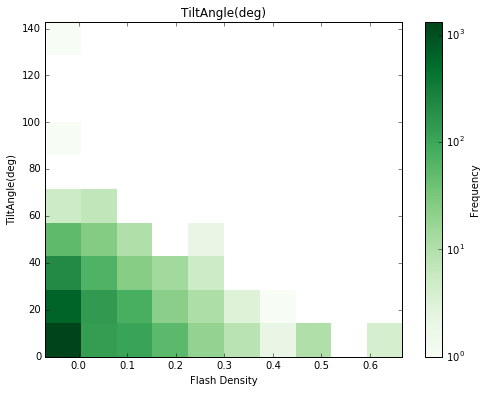

In [70]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(8,6))
_ = plt.hist2d(x=mini_df.FD, y=df['TiltAngle(deg)'], bins=10,norm=LogNorm(), cmap='Greens')
plt.colorbar(label='Frequency')
plt.ylabel('TiltAngle(deg)')
plt.xlabel('Flash Density')
plt.title('TiltAngle(deg)');

In [85]:
print 'Total number of flashes in storm:',mini_df['FC'].sum()
print 'Extra flashes included when ellipse area is doubled:',(mini_df['FC_2'] - mini_df['FC']).sum()

Total number of flashes in storm:  1583.0
Extra flashes included when ellipse area is doubled:  652.0


## Testing area covered by ellipse

In [ ]:
n = 1162
s = mini_df.loc[n,:]
s

In [ ]:
it = tr.get_loc(mini_df.loc[n, 'date_time'])
if it == 0:
    ds0 = ds.cloud_ground[(ds.time>(tr[it] - pd.Timedelta(minutes=5)).asm8) & 
                          (ds.time<=tr[it].asm8) & 
                          (ds.cloud_ground=='G')]
else:
    ds0 = ds.cloud_ground[(ds.time>tr[it-1].asm8) & 
                          (ds.time<=tr[it].asm8) & (ds.cloud_ground=='G')]

117.0
58.0


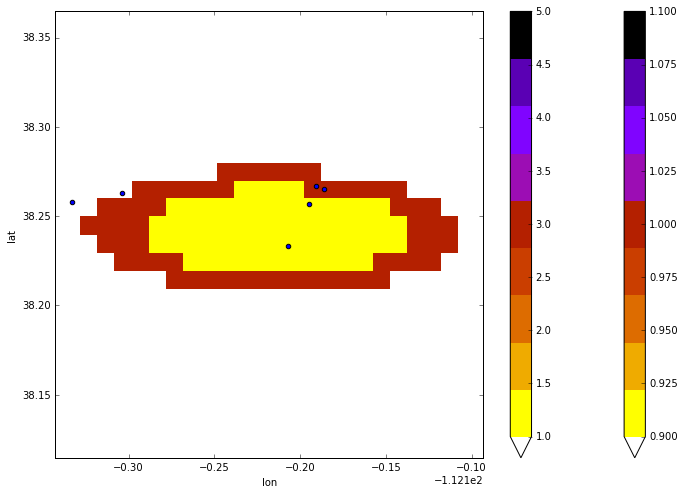

In [51]:
x = np.arange(s.lon-max(s.major, s.minor)/100.-.05,s.lon+max(s.major, s.minor)/100.+.05, .01)
y = np.arange(s.lat-max(s.major, s.minor)/100.-.05,s.lat+max(s.major, s.minor)/100.+.05, .01)
plt.figure(figsize=(12,8))
bool_array = np.zeros((y.shape[0],x.shape[0]))
for xi, xp in enumerate(x):
    for yi, yp in enumerate(y):
        bool_array[yi, xi]=in_envelope(s, yp, xp, 2)
xr.DataArray(bool_array, coords={'lon':x,'lat':y}).plot(cmap=cmap, vmin=1)
print bool_array.sum()

bool_array = np.zeros((y.shape[0],x.shape[0]))
for xi, xp in enumerate(x):
    for yi, yp in enumerate(y):
        bool_array[yi, xi]=in_envelope(s, yp, xp, 1)
xr.DataArray(bool_array, coords={'lon':x,'lat':y}).plot(cmap=cmap, vmin=1, vmax=5)
print bool_array.sum()
#plt.scatter(s.lon, s.lat)
plt.scatter(ds0.lon.values, ds0.lat.values)
plt.ylim(y.min(),y.max())
plt.xlim(x.min(), x.max());

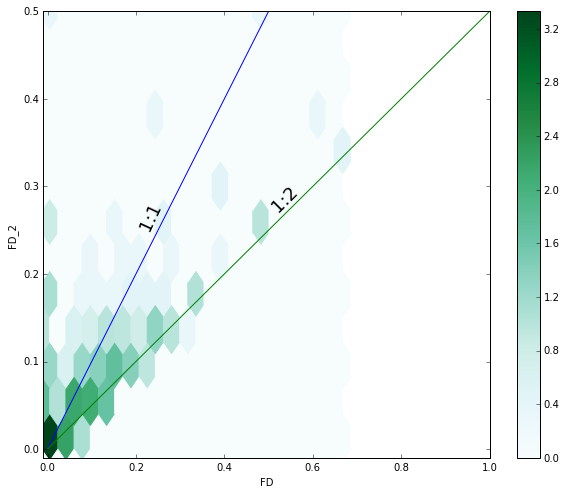

In [119]:
mini_df.plot.hexbin(x='FD', y='FD_2', gridsize=20, bins='log', figsize=(10,8), sharex=False)
plt.ylim(-0.01, .5)
plt.xlim(-.01, 1)
plt.plot([0,1], [0,1]);
plt.annotate('1:1', xy=(0.2, 0.27), rotation=65, fontsize=18)

plt.plot([0,1], [0,.5])
plt.annotate('1:2', xy=(0.5, 0.29), rotation=45, fontsize=18);